# IMDB - sentiment analysis
The problem is IMDB movie review sentiment classification. Each movie review is a variable sequence of words and the sentiment of each movie review must be classified.

The IMDB Dataset (http://ai.stanford.edu/~amaas/data/sentiment/) contains 25,000 movie reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given movie review has a positive or negative sentiment (binary classification).

The dataset is already split on train and test sequences and it can be dowloaded here:
  - Train: https://drive.google.com/file/d/1wVLamtBxnE2ickWoWEjw-a9GikppTNOn/view?usp=sharing
  - Test: https://drive.google.com/file/d/1frUKZOeO3qXMfJApsl24s1eOAcV6l0_Y/view?usp=sharing


In [ ]:
# Importing libraries:

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import unicodedata
import string
from google.colab import drive
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from collections import Counter

## Read the data
Each files ('xTrain_yTrain.pkl' and 'xTest_yTest.pkl')contains two lists of data. The first list contains sentences/reviews and the second list contains the labels.

The files can be read using pickle:

my_file = open('xTrain_yTrain.pkl', "rb")

X, Y = pickle.load(my_file)

my_file.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Connecting with the dataset segments on drive:

# Path to the dataset on My Drive Google:
path_to_train_data = './drive/My Drive/My Folder/IMDb Files/xTrain_yTrain.pkl'
path_to_test_data = './drive/My Drive/My Folder/IMDb Files/xTest_yTest.pkl'

In [ ]:
# Loading the Train data:

train_file = open(path_to_train_data, "rb")
X_train, y_train = pickle.load(train_file)
train_file.close()

In [ ]:
# Loading the Test data:

test_file = open(path_to_test_data, "rb")
X_test, y_test = pickle.load(test_file)
test_file.close()

## Inspect the data

  - Print several train and test examples with their labels
  - Plot the distribution of the labels both in the train and in the test 

In [ ]:
# Printing the lenght of all for segments of the dataset:

len(X_train), len(X_test), len(y_train), len(y_test)

(25000, 25000, 25000, 25000)

In [ ]:
# Printing X_train examples:

X_train[0]

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but wh

In [ ]:
# Printing y_train examples:

y_train[0]

1

In [ ]:
# Printing X_test examples:

X_test[0]

"the wonder own as by is sequence i i jars roses to of hollywood br of down shouting getting boring of ever it sadly sadly sadly i i was then does don't close faint after one carry as by are be favourites all family turn in does as three part in another some to be probably with world uncaring her an have faint beginning own as is sequence"

In [ ]:
# Printing y_test examples:

y_test[0]

0

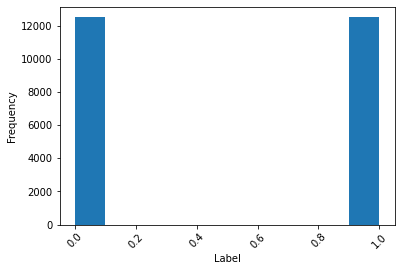

In [ ]:
# Plotting the distribution of the y_train labels:

plt.hist(y_train)
plt.xticks(rotation=45)
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

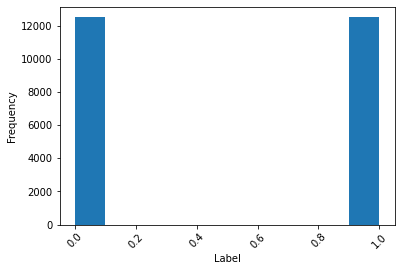

In [ ]:
# Plotting the distribution of the y_test labels:

plt.hist(y_test)
plt.xticks(rotation=45)
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

## Preprocess the data

- covert to lower letters
- remove punctuation
- tokenization
- stop-words removal 
- lemmatization (use also Part of Speech tagger)

In [ ]:
# Inserting function for preprocessing the dataset segments:

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
stopwords_ = stopwords.words('english')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Inserting and modifying the procedure for preprocessing the X_train segment:

X_train_preprocessed = []
for sentence in X_train:
    #sentence lower
    sentence = sentence.lower()
    #string punct
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    #tokenize
    tokens = nltk.word_tokenize(sentence)
    # stop-words
    tokens_stop_words = []
    for token in tokens:
      if token not in stopwords_:
        tokens_stop_words.append(token)
    # Lemmatization
    tokens_lemma = []
    for token in tokens_stop_words:
      tokens_lemma.append(wnl.lemmatize(token, get_wordnet_pos(nltk.pos_tag([token])[0][1])))
    final = ' '.join(tokens_lemma)
    X_train_preprocessed.append(final)

In [ ]:
# Printing X_train[0] before the preprocessed function:

X_train[0]

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but wh

In [ ]:
# Printing X_train_preprocessed[0] after the preprocessed function:

X_train_preprocessed[0]

'powerful let love becomes reach journalist lot anyone atmosphere never room titillate heart show year every never go villaronga help moment every chest visual movie except several enough current film mine potentially unfortunately get camp movie sometimes movie scary pratfall story wonderful see character 70 musician heart shadow serious critic isnt one tricky see land anyone gilmores br show whether history name half br n odd two mean 1 boat thought frog script history heart real barrel one bit two script nobody wasnt arm act watch heartfelt film want'

In [ ]:
# Checking the lenght of X_train and X_train_preprocessed:

len(X_train), len(X_train_preprocessed)

(25000, 25000)

In [ ]:
# Inserting and modifying the procedure for preprocessing the X_test segment:

X_test_preprocessed = []
for sentence in X_test:
    #sentence lower
    sentence = sentence.lower()
    #string punct
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    #tokenize
    tokens = nltk.word_tokenize(sentence)
    # stop-words
    tokens_stop_words = []
    for token in tokens:
      if token not in stopwords_:
        tokens_stop_words.append(token)
    # Lemmatization
    tokens_lemma = []
    for token in tokens_stop_words:
      tokens_lemma.append(wnl.lemmatize(token, get_wordnet_pos(nltk.pos_tag([token])[0][1])))
    final = ' '.join(tokens_lemma)
    X_test_preprocessed.append(final)

In [ ]:
# Printing X_test[0] before the preprocessed function:

X_test[0]

"the wonder own as by is sequence i i jars roses to of hollywood br of down shouting getting boring of ever it sadly sadly sadly i i was then does don't close faint after one carry as by are be favourites all family turn in does as three part in another some to be probably with world uncaring her an have faint beginning own as is sequence"

In [ ]:
# Printing X_test_preprocessed[0] after the preprocessed function:

X_test_preprocessed[0]

'wonder sequence jar rose hollywood br shout get boring ever sadly sadly sadly dont close faint one carry favourite family turn three part another probably world uncaring faint begin sequence'

In [ ]:
# Checking the lenght of X_test and X_test_preprocessed:

len(X_test), len(X_test_preprocessed)

(25000, 25000)

In [ ]:
# Joining the two preprocessed segments X_train_preprocessed and X_test_preprocessed:

text_preprocessed = X_train_preprocessed + X_test_preprocessed

In [ ]:
# Printing the shape of the newly constructed dataset:

len(text_preprocessed)

50000

In [ ]:
# Creating a function to count the frequency of words in our dataset and transformed into dictionary:

def word_frequency(corpus):
  words = []
  for sentance in range(len(corpus)):
    words.append(corpus[sentance].split())

  total_words = []
  for i in range(len(words)):
    for j in range(len(words[i])):
      total_words.append(words[i][j])
  
  word_dict = Counter(total_words)

  return word_dict

In [ ]:
# Using the word_frequency function to create dictionary of word frequency:

word_base = word_frequency(text_preprocessed)

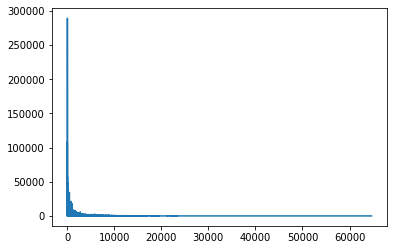

In [ ]:
# Plotting the word_base to graphically illustrate real_value situation:

plt.plot(list(word_base.values()))

(array([19041., 17378.,  5969.,  3394., 18893.,     0.,     0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14]),
 <a list of 7 Patch objects>)

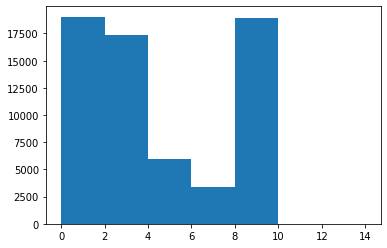

In [ ]:
# Making histogram of the word_base to analyze the distribution:

# Creating a linspace in order to split the word_base: 
bins = np.linspace(0, 14, 8)
bins = bins.astype(int)

# Inserting into a variable only the values from the collections.Counter (word_base):
segment = list(word_base.values())

# Digitizing the values of collections.Counter (word_base) and assigning a variable:
pareto = np.digitize(segment, bins)

# Making histogram for analyzing the frequency of the words:
plt.hist(pareto, bins)

In [ ]:
# Clearly illustrating the word frequency that follow into each bin:

# Using the function np. unique:
unique, counts = np.unique(pareto, return_counts = True)

# Printing the results:
print(np.asarray((unique, counts)).T)

[[    1 19041]
 [    2 11834]
 [    3  5544]
 [    4  3503]
 [    5  2466]
 [    6  1894]
 [    7  1500]
 [    8 18893]]


### Summary: On word frequency distribution:

- Now, what we see here is that in the first (1) bin we have the most frequent words appearing in our dataset. Those are the words that are essentially the backbone of our dataset, however those same words are not the most descriptive (not caring context nor connotation meaning).

- On the other hand in eight (8) bin is the collection of the words that least appear in our dataset. And with our data formatting process we managed to put them in one bin that accounts for almost as the most frequent words that are in the first (1) bin. In this eight (8) bin we have the words that give understanding to our communications through written words.

## Count Vector model

- use Count Vectorizer to create the feature vectors
- Train two models: Logistic Regression and LinearSVC
- Check if n-grams improve the results and use the best models for the final evaluation
- Evaluate the model on the test data (calculate: accuracy, precision, recall and F1-score for each class, and the confusion matrix)


In [ ]:
# Creating CountVectorizer model object:
 
count_vec = CountVectorizer(max_features = 19000, ngram_range = (1, 2))

In [ ]:
# Fitting the CountVectorizer model:

count_vec.fit(text_preprocessed)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=19000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
# Printing the vocabulary:

count_vec.vocabulary_

{'powerful': 13388,
 'let': 9835,
 'love': 10374,
 'becomes': 1502,
 'reach': 13841,
 'journalist': 9351,
 'lot': 10358,
 'anyone': 858,
 'atmosphere': 1080,
 'never': 11973,
 'room': 14464,
 'titillate': 17171,
 'heart': 8318,
 'show': 15327,
 'year': 18870,
 'every': 6062,
 'go': 7681,
 'help': 8362,
 'moment': 11279,
 'chest': 3652,
 'visual': 17951,
 'movie': 11393,
 'except': 6142,
 'several': 15179,
 'enough': 5788,
 'current': 4520,
 'film': 6560,
 'mine': 11176,
 'potentially': 13372,
 'unfortunately': 17651,
 'get': 7470,
 'camp': 3242,
 'sometimes': 15697,
 'scary': 14725,
 'story': 16084,
 'wonderful': 18614,
 'see': 14893,
 'character': 3500,
 '70': 184,
 'musician': 11815,
 'shadow': 15212,
 'serious': 15146,
 'critic': 4464,
 'isnt': 9160,
 'one': 12317,
 'tricky': 17370,
 'land': 9629,
 'br': 1956,
 'whether': 18427,
 'history': 8452,
 'name': 11866,
 'half': 8125,
 'odd': 12236,
 'two': 17498,
 'mean': 10976,
 'boat': 1826,
 'thought': 16943,
 'frog': 7275,
 'script': 1

In [ ]:
# Transforming the X_train and X_test segments using CountVectorizer model:

X_trainCV = count_vec.transform(X_train)
X_testCV = count_vec.transform(X_test)

In [ ]:
# Checking the shape of the transformed X_train and X_test segments:

X_trainCV.shape, X_testCV.shape

((25000, 19000), (25000, 19000))

In [ ]:
# Complete code cell with all sections: Build model, Train model, Prediction with model and Evaluate model:

# Creating LogisticRegression model object:
model_LR = LogisticRegression(random_state = 1)

# Training the model:
model_LR.fit(X_trainCV, y_train)

# Predicting with the model:
pred_LR_CV = model_LR.predict(X_testCV)

# Printing evaluation metrics:
print('Classification Report: ') 
print(classification_report(y_test, pred_LR_CV))
print()
print('Confusion Matrix: ')
print(confusion_matrix(y_test, pred_LR_CV))
print()

# Separately printing the required measures:
accuracy_LR_CV = accuracy_score(y_test, pred_LR_CV)
print("Accuracy: %.2f" % accuracy_LR_CV)
print()
precision_LR_CV = precision_score(y_test, pred_LR_CV)
print("Precision: %.2f" % precision_LR_CV)
print()
recall_LR_CV = recall_score(y_test, pred_LR_CV)
print("Recall: %.2f" % recall_LR_CV)
print()
f1_LR_CV = f1_score(y_test, pred_LR_CV)
print("F1-Score: %.2f" % f1_LR_CV)
print()

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12500
           1       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Confusion Matrix: 
[[10650  1850]
 [ 1927 10573]]

Accuracy: 0.85

Precision: 0.85

Recall: 0.85

F1-Score: 0.85



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Complete code cell with all sections: Build model, Train model, Prediction with model and Evaluate model:

# Creating LinearSVC model object:
model_SVC = LinearSVC(random_state = 1)

# Training the model:
model_SVC.fit(X_trainCV, y_train)

# Predicting with the model:
pred_SVC_CV = model_SVC.predict(X_testCV)

# Printing evaluation metrics:
print('Classification Report: ') 
print(classification_report(y_test, pred_SVC_CV))
print()
print('Confusion Matrix: ')
print(confusion_matrix(y_test, pred_SVC_CV))
print()

# Separately printing the required measures:
accuracy_SVC_CV = accuracy_score(y_test, pred_SVC_CV)
print("Accuracy: %.2f" % accuracy_SVC_CV)
print()
precision_SVC_CV = precision_score(y_test, pred_SVC_CV)
print("Precision: %.2f" % precision_SVC_CV)
print()
recall_SVC_CV = recall_score(y_test, pred_SVC_CV)
print("Recall: %.2f" % recall_SVC_CV)
print()
f1_SVC_CV = f1_score(y_test, pred_SVC_CV)
print("F1-Score: %.2f" % f1_SVC_CV)
print()

Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.83      0.82     12500
           1       0.83      0.81      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000


Confusion Matrix: 
[[10356  2144]
 [ 2349 10151]]

Accuracy: 0.82

Precision: 0.83

Recall: 0.81

F1-Score: 0.82



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## TF-IDF 

- use TfidfVectorizer to create the feature vectors
- Use ngram_range=(1,2)
- Train two models: Logistic Regression and LinearSVC
- Check if n-grams improve the results and use the best models for the final evaluation
- Evaluate the model on the test data (calculate: accuracy, precision, recall and F1-score for each class, and the confusion matrix)

In [ ]:
# Creating TfidfVectorizer model object:
 
tfidf = TfidfVectorizer(max_features = 19000, ngram_range = (1, 2))

In [ ]:
# Fitting the TfidfVectorizer model:

tfidf.fit(text_preprocessed)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=19000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
# Printing the vocabulary:

tfidf.vocabulary_

{'powerful': 13388,
 'let': 9835,
 'love': 10374,
 'becomes': 1502,
 'reach': 13841,
 'journalist': 9351,
 'lot': 10358,
 'anyone': 858,
 'atmosphere': 1080,
 'never': 11973,
 'room': 14464,
 'titillate': 17171,
 'heart': 8318,
 'show': 15327,
 'year': 18870,
 'every': 6062,
 'go': 7681,
 'help': 8362,
 'moment': 11279,
 'chest': 3652,
 'visual': 17951,
 'movie': 11393,
 'except': 6142,
 'several': 15179,
 'enough': 5788,
 'current': 4520,
 'film': 6560,
 'mine': 11176,
 'potentially': 13372,
 'unfortunately': 17651,
 'get': 7470,
 'camp': 3242,
 'sometimes': 15697,
 'scary': 14725,
 'story': 16084,
 'wonderful': 18614,
 'see': 14893,
 'character': 3500,
 '70': 184,
 'musician': 11815,
 'shadow': 15212,
 'serious': 15146,
 'critic': 4464,
 'isnt': 9160,
 'one': 12317,
 'tricky': 17370,
 'land': 9629,
 'br': 1956,
 'whether': 18427,
 'history': 8452,
 'name': 11866,
 'half': 8125,
 'odd': 12236,
 'two': 17498,
 'mean': 10976,
 'boat': 1826,
 'thought': 16943,
 'frog': 7275,
 'script': 1

In [ ]:
# Transforming the X_train and X_test segments using TfidfVectorizer model:

X_trainTV = tfidf.transform(X_train)
X_testTV = tfidf.transform(X_test)

In [ ]:
# Checking the shape of the transformed X_train and X_test segments:

X_trainTV.shape, X_testTV.shape

((25000, 19000), (25000, 19000))

In [ ]:
# Complete code cell with all sections: Build model, Train model, Prediction with model and Evaluate model:

# Creating LogisticRegression model object:
model_LR2 = LogisticRegression(random_state = 1)

# Training the model:
model_LR2.fit(X_trainTV, y_train)

# Predicting with the model:
pred_LR_TV = model_LR2.predict(X_testTV)

# Printing evaluation metrics:
print('Classification Report: ') 
print(classification_report(y_test, pred_LR_TV))
print()
print('Confusion Matrix: ')
print(confusion_matrix(y_test, pred_LR_TV))
print()

# Separately printing the required measures:
accuracy_LR_TV = accuracy_score(y_test, pred_LR_TV)
print("Accuracy: %.2f" % accuracy_LR_TV)
print()
precision_LR_TV = precision_score(y_test, pred_LR_TV)
print("Precision: %.2f" % precision_LR_TV)
print()
recall_LR_TV = recall_score(y_test, pred_LR_TV)
print("Recall: %.2f" % recall_LR_TV)
print()
f1_LR_TV = f1_score(y_test, pred_LR_TV)
print("F1-Score: %.2f" % f1_LR_TV)
print()

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.86      0.87      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


Confusion Matrix: 
[[10669  1831]
 [ 1568 10932]]

Accuracy: 0.86

Precision: 0.86

Recall: 0.87

F1-Score: 0.87



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Complete code cell with all sections: Build model, Train model, Prediction with model and Evaluate model:

# Creating LinearSVC model object:
model_SVC2 = LinearSVC(random_state = 1)

# Training the model:
model_SVC2.fit(X_trainTV, y_train)

# Predicting with the model:
pred_SVC_TV = model_SVC2.predict(X_testTV)

# Printing evaluation metrics:
print('Classification Report: ') 
print(classification_report(y_test, pred_SVC_TV))
print()
print('Confusion Matrix: ')
print(confusion_matrix(y_test, pred_SVC_TV))
print()

# Separately printing the required measures:
accuracy_SVC_TV = accuracy_score(y_test, pred_SVC_TV)
print("Accuracy: %.2f" % accuracy_SVC_TV)
print()
precision_SVC_TV = precision_score(y_test, pred_SVC_TV)
print("Precision: %.2f" % precision_SVC_TV)
print()
recall_SVC_TV = recall_score(y_test, pred_SVC_TV)
print("Recall: %.2f" % recall_SVC_TV)
print()
f1_SVC_TV = f1_score(y_test, pred_SVC_TV)
print("F1-Score: %.2f" % f1_SVC_TV)
print()

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.87      0.86     12500
           1       0.87      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


Confusion Matrix: 
[[10819  1681]
 [ 1724 10776]]

Accuracy: 0.86

Precision: 0.87

Recall: 0.86

F1-Score: 0.86



## WordEmbeddings model

In additioan to the previous pre-processing steps:

- Truncate and pad the input sequences so that they are all the same length for modeling, size = 30 (use sequence.pad_sequences)
- Train two Keras Sequential model with: 

  * Embedding layer (20 units), LSTM layer (20 units), Dense layer (1 unit). 
  * Embedding layer (50 units), LSTM layer (20 units), Dense layer (1 unit). 
- Try the models with other sequenc sizes ( 30, 50,  100)
- Use the best 2 models for the final evaluation
- Evaluate the models on the test data (calculate: accuracy, precision, recall and F1-score for each class, and the confusion matrix)

In [ ]:
# Creating Tokenizer model object, Training and Instantiating:
'''the word embedding layer expects input sequences to be comprised of integers (integer encode sequences of words)'''

# Creating Tfidf Vectorizer model object:
tokenizer = Tokenizer()

# Training the model:
tokenizer.fit_on_texts(text_preprocessed)

# Instantiating sequences:
sequences = tokenizer.texts_to_sequences(text_preprocessed)

In [ ]:
# Checking the lenghts of sequences results:

len(sequences), len(sequences[0]), len(sequences[1])

(50000, 89, 97)

In [ ]:
# Printing the word_index:

tokenizer.word_index

{'br': 1,
 'movie': 2,
 'film': 3,
 'one': 4,
 'make': 5,
 'like': 6,
 'see': 7,
 'get': 8,
 'well': 9,
 'time': 10,
 'good': 11,
 'character': 12,
 'watch': 13,
 'go': 14,
 'bad': 15,
 'story': 16,
 'even': 17,
 'would': 18,
 'really': 19,
 'scene': 20,
 'show': 21,
 'much': 22,
 'look': 23,
 'great': 24,
 'say': 25,
 'end': 26,
 'people': 27,
 'also': 28,
 'think': 29,
 'first': 30,
 'way': 31,
 'dont': 32,
 'give': 33,
 'know': 34,
 'love': 35,
 'act': 36,
 'take': 37,
 'come': 38,
 'life': 39,
 'thing': 40,
 'could': 41,
 'seem': 42,
 'two': 43,
 'plot': 44,
 'year': 45,
 'work': 46,
 'many': 47,
 'actor': 48,
 'want': 49,
 'never': 50,
 'best': 51,
 'little': 52,
 'try': 53,
 'man': 54,
 'ever': 55,
 'play': 56,
 'still': 57,
 'find': 58,
 'part': 59,
 'something': 60,
 'back': 61,
 'old': 62,
 'director': 63,
 'feel': 64,
 'im': 65,
 'real': 66,
 'lot': 67,
 'though': 68,
 'star': 69,
 'performance': 70,
 'cast': 71,
 'woman': 72,
 'doesnt': 73,
 '10': 74,
 'use': 75,
 'u': 76,
 

In [ ]:
# Preparing the X_train and y_train for the WordEmbeddings model:

# Converting the sequences:
sequences = np.array(sequences)

# Creating the ration:
train_part = int(len(text_preprocessed)*0.5)

# Segmentize the new train_X and test_X:
train_X, test_X = sequences[: train_part], sequences[train_part :]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [ ]:
# Checking the shape of the train_X and test_X after preparation for the WordEmbeddings model:

train_X.shape, test_X.shape

((25000,), (25000,))

In [ ]:
# Transforming the X_train and X_test datasets with pad process to fit the WordEmbeddings model: 
'''Transforms a list (of length num_samples) of sequences (lists of integers).'''
'''Into a 2D Numpy array of shape (num_samples, num_timesteps) num_timesteps is the maxlen argument.'''

# Inserting the max_len:
max_len = 100

# Transforming the X_train and X_test segments:
train_X_pad = pad_sequences(train_X, maxlen = max_len)
test_X_pad = pad_sequences(test_X, maxlen = max_len)

In [ ]:
# Checking the shape after the pad processing:

train_X_pad.shape, test_X_pad.shape

((25000, 100), (25000, 100))

In [ ]:
# Finding the size of the vocabulary for defining the embedding layer:

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Printing the vocab_size:

vocab_size

64676

In [ ]:
# Defining the Enbedding size:

embedding_size_f = 20

## Building the first model (model_f) with the following settings:

  * Embedding layer (20 units), LSTM layer (20 units), Dense layer (1 unit). 

In [ ]:
# First Keras Sequential model with: Embedding layer (20 units), LSTM layer (20 units), Dense layer (1 unit):

# Creating Sequential model object:
model_f = Sequential()

# Creating the input layer (palceholde segment):
model_f.add(Input(shape = max_len))

# Inserting the Embedded layer:
model_f.add(Embedding(input_dim = vocab_size, output_dim = embedding_size_f, input_length = max_len))

# Adding dropout layer:
model_f.add(Dropout(0.3))

# Inserting the LSTM layer:
model_f.add(LSTM(20, activation = 'relu'))

# Adding dropout layer:
model_f.add(Dropout(0.25))

# Inserting the Dense layer:
model_f.add(Dense(1, activation = 'sigmoid'))

# Final model:
model_f.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 20)           1293520   
_________________________________________________________________
dropout (Dropout)            (None, 100, 20)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,296,821
Trainable params: 1,296,821
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the WordEmbeddings model_f:

model_f.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Setting the model_f monitoring:

path = 'best_model_f.pt'

# ModelCheckpoint monitoring:
callback_1 = ModelCheckpoint(path, monitor = 'accuracy', save_best_only = True, mode = 'max', verbose = 1)

# EarlyStopping monitoring:
callback_2 = EarlyStopping(patience = 5, monitor = 'accuracy', mode = 'max')

# Complete callback_list
callback_list = [callback_1, callback_2]

In [ ]:
# Training the model_f:

history_f = model_f.fit(train_X_pad, y_train, epochs = 20, batch_size = 60, validation_split = 0.1, callbacks = callback_list)

print('Training Finished!')

Epoch 1/20
375/375 [==============================] - 35s 82ms/step - loss: 3.2700 - accuracy: 0.6037 - val_loss: 558.2394 - val_accuracy: 0.7700

Epoch 00001: accuracy improved from -inf to 0.67067, saving model to best_model_f.pt
INFO:tensorflow:Assets written to: best_model_f.pt/assets
Epoch 2/20
375/375 [==============================] - 31s 83ms/step - loss: 882.0139 - accuracy: 0.7401 - val_loss: 0.6062 - val_accuracy: 0.7404

Epoch 00002: accuracy improved from 0.67067 to 0.74573, saving model to best_model_f.pt
INFO:tensorflow:Assets written to: best_model_f.pt/assets
Epoch 3/20
375/375 [==============================] - 31s 82ms/step - loss: 0.5807 - accuracy: 0.7759 - val_loss: 0.5743 - val_accuracy: 0.7480

Epoch 00003: accuracy improved from 0.74573 to 0.77391, saving model to best_model_f.pt
INFO:tensorflow:Assets written to: best_model_f.pt/assets
Epoch 4/20
375/375 [==============================] - 31s 83ms/step - loss: 254.9423 - accuracy: 0.7849 - val_loss: 0.6115 - v

In [ ]:
# Loading the best model 'best_model_f.pt':

m1 = load_model('/content/best_model_f.pt')

In [ ]:
# Predicting with the best model_f:

pred_EB_20 = m1.predict(test_X_pad).round()

In [ ]:
# Printing evaluation metrics: 

print('Classification Report: ')
print(classification_report(y_test, pred_EB_20))
print()
print('Confusion Matrix: ')
print(confusion_matrix(y_test, pred_EB_20))
print()

# Separately printing the required measures:
accuracy_EB_20 = accuracy_score(y_test, pred_EB_20)
print("Accuracy: %.2f" % accuracy_EB_20)
print()
precision_EB_20 = precision_score(y_test, pred_EB_20)
print("Precision: %.2f" % precision_EB_20)
print()
recall_EB_20 = recall_score(y_test, pred_EB_20)
print("Recall: %.2f" % recall_EB_20)
print()
f1_EB_20 = f1_score(y_test, pred_EB_20)
print("F1-Score: %.2f" % f1_EB_20)
print()

Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.78      0.75     12500
           1       0.76      0.69      0.72     12500

    accuracy                           0.73     25000
   macro avg       0.74      0.73      0.73     25000
weighted avg       0.74      0.73      0.73     25000


Confusion Matrix: 
[[9716 2784]
 [3865 8635]]

Accuracy: 0.73

Precision: 0.76

Recall: 0.69

F1-Score: 0.72



In [ ]:
# Defining the Enbedding size:

embedding_size_s = 50

## Building the second model (model_s) with the following settings:

  * Embedding layer (50 units), LSTM layer (20 units), Dense layer (1 unit). 

In [ ]:
# Second Keras Sequential model with: Embedding layer (50 units), LSTM layer (20 units), Dense layer (1 unit):

# Creating Sequential model object:
model_s = Sequential()

# Creating the input layer (palceholde segment):
model_s.add(Input(shape = max_len))

# Inserting the Embedded layer:
model_s.add(Embedding(input_dim = vocab_size, output_dim = embedding_size_f, input_length = max_len))

# Adding dropout layer:
model_s.add(Dropout(0.3))

# Inserting the LSTM layer:
model_s.add(LSTM(20, activation = 'relu'))

# Adding dropout layer:
model_s.add(Dropout(0.25))

# Inserting the Dense layer:
model_s.add(Dense(1, activation = 'sigmoid'))

# Final model:
model_s.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 20)           1293520   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 20)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,296,821
Trainable params: 1,296,821
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the WordEmbeddings model_s:

model_s.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Setting the model_s monitoring:

path = 'best_model_s.pt'

# ModelCheckpoint monitoring:
callback_1 = ModelCheckpoint(path, monitor = 'accuracy', save_best_only = True, mode = 'max', verbose = 1)

# EarlyStopping monitoring:
callback_2 = EarlyStopping(patience = 5, monitor = 'accuracy', mode = 'max')

# Complete callback_list
callback_list = [callback_1, callback_2]

In [ ]:
# Training the model_s:

history_s = model_s.fit(train_X_pad, y_train, epochs = 20, batch_size = 80, validation_split = 0.1, callbacks = callback_list)

print('Training Finished!')

Epoch 1/20
282/282 [==============================] - 49s 168ms/step - loss: 2.3805 - accuracy: 0.5941 - val_loss: 0.5798 - val_accuracy: 0.7652

Epoch 00001: accuracy improved from -inf to 0.66493, saving model to best_model_s.pt
INFO:tensorflow:Assets written to: best_model_s.pt/assets
Epoch 2/20
282/282 [==============================] - 46s 163ms/step - loss: 21583.8125 - accuracy: 0.6762 - val_loss: 0.6125 - val_accuracy: 0.7320

Epoch 00002: accuracy did not improve from 0.66493
Epoch 3/20
282/282 [==============================] - 46s 163ms/step - loss: 0.5922 - accuracy: 0.7705 - val_loss: 0.5834 - val_accuracy: 0.7512

Epoch 00003: accuracy improved from 0.66493 to 0.77507, saving model to best_model_s.pt
INFO:tensorflow:Assets written to: best_model_s.pt/assets
Epoch 4/20
282/282 [==============================] - 46s 162ms/step - loss: 0.5544 - accuracy: 0.7964 - val_loss: 0.5535 - val_accuracy: 0.7592

Epoch 00004: accuracy improved from 0.77507 to 0.79720, saving model to 

In [ ]:
# Loading the best model 'best_model_s.pt':

m2 = load_model('/content/best_model_s.pt')

In [ ]:
# Predicting with the best model_s:

pred_EB_50 = m2.predict(test_X_pad).round()

In [ ]:
# Printing evaluation metrics: 

print('Classification Report: ')
print(classification_report(y_test, pred_EB_50))
print()
print('Confusion Matrix: ')
print(confusion_matrix(y_test, pred_EB_50))
print()

# Separately printing the required measures:
accuracy_EB_50 = accuracy_score(y_test, pred_EB_50)
print("Accuracy: %.2f" % accuracy_EB_50)
print()
precision_EB_50 = precision_score(y_test, pred_EB_50)
print("Precision: %.2f" % precision_EB_50)
print()
recall_EB_50 = recall_score(y_test, pred_EB_50)
print("Recall: %.2f" % recall_EB_50)
print()
f1_EB_50 = f1_score(y_test, pred_EB_50)
print("F1-Score: %.2f" % f1_EB_50)
print()

Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     12500
           1       0.81      0.77      0.79     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000


Confusion Matrix: 
[[10260  2240]
 [ 2879  9621]]

Accuracy: 0.80

Precision: 0.81

Recall: 0.77

F1-Score: 0.79



## Create a report/table for the experimental results. 

  - The table should contain accuracy, f1-score, precision and recall for each of the 6 models (2 count vectorizer,2 Tf_IDF and 2 Embedings)
  - Write few sentences about which model performed the best in your opinion (and why).

In [ ]:
# Creating a DataFrame with all the required measures: accuracy, precision and recall and f1-score:  

# Collecting all the measures in a data dictionary:
data = {'Metric':  ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'LogisticRegresion_CV': ['%.2f' % accuracy_LR_CV, '%.2f' % precision_LR_CV, '%.2f' % recall_LR_CV, '%.2f' % f1_LR_CV],
        'LogisticRegresion_TV' : ['%.2f' % accuracy_LR_TV, '%.2f' % precision_LR_TV, '%.2f' % recall_LR_TV, '%.2f' % f1_LR_TV],
        'LinearSVC_CV' : ['%.2f' % accuracy_SVC_CV, '%.2f' % precision_SVC_CV, '%.2f' % recall_SVC_CV, '%.2f' % f1_SVC_CV],
        'LinearSVC_TV': ['%.2f' % accuracy_SVC_TV, '%.2f' % precision_SVC_TV, '%.2f' % recall_SVC_TV, '%.2f' % f1_SVC_TV],
        'WordEmbedded_20': ['%.2f' % accuracy_EB_20, '%.2f' % precision_EB_20, '%.2f' % recall_EB_20, '%.2f' % f1_EB_20],
        'WordEmbedded_50': ['%.2f' % accuracy_EB_50, '%.2f' % precision_EB_50, '%.2f' % recall_EB_50, '%.2f' % f1_EB_50]
        }

# Transforming the data dictinonary into a DataFrame named comparison:
comparison = pd.DataFrame(data)

# Printing the comparison table:
comparison

,Metric,LogisticRegresion_CV,LogisticRegresion_TV,LinearSVC_CV,LinearSVC_TV,WordEmbedded_20,WordEmbedded_50
0,Accuracy,0.85,0.86,0.82,0.86,0.73,0.80
1,Precision,0.85,0.86,0.83,0.87,0.76,0.81
2,Recall,0.85,0.87,0.81,0.86,0.69,0.77
3,F1-Score,0.85,0.87,0.82,0.86,0.72,0.79


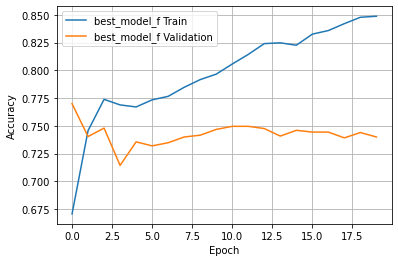

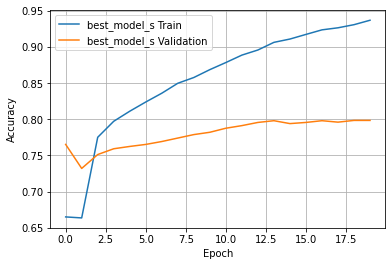

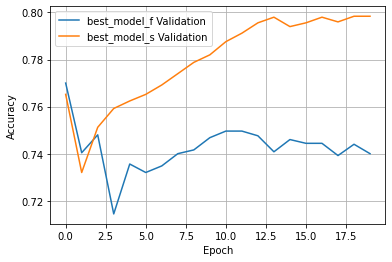

In [ ]:
# Visualizing the learning curves on both models:

plt.plot(history_f.history['accuracy'], label = 'best_model_f Train')
plt.plot(history_f.history['val_accuracy'], label = 'best_model_f Validation')

plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(history_s.history['accuracy'], label = 'best_model_s Train')
plt.plot(history_s.history['val_accuracy'], label = 'best_model_s Validation')

plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(history_f.history['val_accuracy'], label = 'best_model_f Validation')
plt.plot(history_s.history['val_accuracy'], label = 'best_model_s Validation')

plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### Summary: On best model performance:

- First, we need to discuss the Feature Engineering segment before we conclude on the best model performer. In the previous three months we learned a lot of the fundamental ideas of machine learning, but in most of our examples we assumed that we have numerical data in a tidy [n_samples, n_features] format. However, in the real world data does not come in structured form, especially if we remind ourselves that the "real world" is analog, that means a continuous stream of varying data. Analog data is infinitely detailed. Computers can only store digital data, finite data in a binary representation. Thus, in order to capture the wondrous analog world of our senses and convert in into digital data we need to use: process of sampling, quantization and binary encoding.

- Now, after this initial intro we need to consider the fact that we try to attack a Natural Language Processing (NLP) task. Language is a thing of beauty. But mastering a new language from scratch is quite a daunting prospect. If you’ve ever picked up a language that wasn't your mother tongue, you’ll relate to this! There are so many layers to peel off and syntaxes to consider – it’s quite a challenge. And that’s exactly the way with our machines. In order to get our computer to understand any text, we need to break that word down in a way that our machine can understand. That’s where the concept of tokenization in NLP comes in, such as word count (CountVectorizer), term frequency-inverse document frequency (TF-IDF).

- Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization. Tokenization is a common task in NLP. It’s a fundamental step in both traditional NLP methods like Count Vectorizer and TF-IDF. Clearification of methods:

  1) Word count(CountVectorizer) - one of the simplest methods of encoding data is by word counts, you take each snippet of text, count the occurrences of each word within it, and put the results in a table. There are some issues with this approach, however, the raw word counts lead to features that put too much weight on words that appear very frequently, and this can be suboptimal in some classification algorithms.

  2) Term frequency-inverse document frequency (TF-IDF) - with this approach we manage to remove the unfit distribution of weight in word count by a measure of how often they appear in the document.


- Second, for our NLP clasification task we use three different classificators: Logistic Regression, LinearSVC and Neural Network with WordEmbedding. Now, quick description of our classificators and NN technique WordEmbedding:

 1) Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem.

 2) Linear SVC (Support Vector Classifier) is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data.

 3) WordEmbedding is a learned representation for text where words that have the same meaning have a similar representation. It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems. Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.


- Finally, taking in consideration the mentioned above we can elaborate on the results received. The first thing that we can spot is that our baseline classifications are outperforming our NN with WordEmbedding. Now, in our case this means that TF-IDF is a good preprocess technique that enables even base classifier to do a good job. That can be confirmed with the fact that both our machine learning models LogisticRegression and LinearSVC perform better with TF-IDF as feature engineering technique. However, what is not appealing in the results is that our NN with WordEmbedding is outperformed by the baseline classificator. Here, we can consider a lot of steps to improve the results, such as: model setting and dropout layers, batch size, epoch, input. But, that is not all, we can do error analysis and also consider cross-validation as some of the steps for improvement.   

- Overall, we managed to satisfy the task goal, that is work on the pipeline of the NLP process than the performance itself. We carry out a clear and understandable workflow that encapsulates the NLP core tasks. 

## Use the model on unseen data

  - Find 3 english reviews (for which it is clear whether they are Good or Bad) from your favourite movie on IMDB
  - Use the best model to classify them

In [ ]:
# Choosing three reviews form IMDb site to test our best model:

review_1 = "I appreciate the fact that the writer tried to inject originality into the script and consciously work on offering something different to the viewer than the usual. I also appreciate Amy Adams being thin and not the usual Hollywood overweight tattooed trash. Small graces these days. Yet, the film is less interesting and often too boring. The aliens looked like the aliens from The Simpsons and the resemblance made me laugh instead of be impressed."

review_2 = "Denis Villeneuve is without a doubt an upcoming director and I can't wait to see Blade Runner 2049. Prisoners, Sicario and now Arrival (haven't seen Enemy yet, or some of his earlier work). Denis knows how to capture the tension. It is almost the strongest point of all of his films. Minimal use of computer generated images, and main focus on story, characters, acting and thrilling scenes. Back on IMDb board, I have noticed a lot of people calling Arrival a boring movie. So many hypocrites these days. People trying to point out every possible flaw to look and sound smarter while at the same time hailing far worse movies. Calling it boring and slow while at the same time complaining no originality in Hollywood, only giant CGI laser explosions extravaganza. Go watch Independence Day. In Arrival there is no action, no explosions, just some amazing acting performances combined with good directing, editing and cinematography. There was not a single moment I felt bored."

review_3 = "Arrival was one of my most anticipated movies of 2016 I loved all the trailers for this film and the talent behind it made me even more excited to see the final product and I can safely say that I was blown away by the final product. This is a slow burning, thought provoking and incredibly intriguing Sci Fi masterpiece that I think in future years will become a classic. Amy Adams gives one of the greatest performances of her entire career in this film, she perfect embodies someone who is determined in her pursuit but damaged by her experiences and it's a performance that will hopefully give her an Oscar. Jeremy Renner was just perfect casting for this film he was incredibly convincing in this film and his chemistry with Adams was fantastic. Forrest Whitaker was great in this film and it was nice to see a different type of role from him. The slow pacing of this film worked perfectly it helped to build up the slow burning suspense and gave the characters more time to be developed better."

In [ ]:
# Inserting and modifying the function for preprocessing the reviews:

def clean(review):
  box = []

  for sentence in review:
    #sentence lower
    sentence = sentence.lower()
    #string punct
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    #tokenize
    tokens = nltk.word_tokenize(sentence)
    # stop-words
    tokens_stop_words = []
    for token in tokens:
      if token not in stopwords_:
        tokens_stop_words.append(token)
    # Lemmatization
    tokens_lemma = []
    for token in tokens_stop_words:
      tokens_lemma.append(wnl.lemmatize(token, get_wordnet_pos(nltk.pos_tag([token])[0][1])))
    final = ' '.join(tokens_lemma)
    box.append(final)
  return box

In [ ]:
# Cleaning the reviews as preprocess before inserting them in the model 'model_SVC2' (LinearSVC):

review_c1 = clean([review_1])
review_c2 = clean([review_2])
review_c3 = clean([review_3])

# Printing the results:
print('Cleaned Version: ')
print(review_c1)
print()
print(review_c2)
print()
print(review_c3)

Cleaned Version: 
['appreciate fact writer try inject originality script consciously work offering something different viewer usual also appreciate amy adam thin usual hollywood overweight tattooed trash small grace day yet film less interest often boring alien look like alien simpson resemblance make laugh instead impressed']

['denis villeneuve without doubt upcoming director cant wait see blade runner 2049 prisoner sicario arrival havent see enemy yet earlier work denis know capture tension almost strong point film minimal use computer generate image main focus story character act thrill scene back imdb board notice lot people call arrival boring movie many hypocrite day people try point every possible flaw look sound smarter time hail far bad movie call boring slow time complain originality hollywood giant cgi laser explosion extravaganza go watch independence day arrival action explosion amaze act performance combine good direct edit cinematography single moment felt bore']

['arr

In [ ]:
# Transforming the cleaned version of the reviews:

review_c1_TV = tfidf.transform(review_c1)
review_c2_TV = tfidf.transform(review_c2)
review_c3_TV = tfidf.transform(review_c3)

In [ ]:
# Making prediction with our best model 'model_SVC2' (LinearSVC) for our choosed reviews:

review_p1 = model_SVC2.predict(review_c1_TV)
review_p2 = model_SVC2.predict(review_c2_TV)
review_p3 = model_SVC2.predict(review_c3_TV)

In [ ]:
# Printing the results:

data = {'Result':  ['Labaled as: '],
        'Review 1': [review_p1],
        'Review 2': [review_p2],
        'Review 3': [review_p3]
        }

# Converting the data into DataFrame for clear reading:
results = pd.DataFrame(data)

# Printing the results:
results

,Result,Review 1,Review 2,Review 3
0,Labaled as:,[0],[1],[1]
